In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

df= pd.read_csv('network_intrusion_data.csv',header= None,na_values=['NA','?'])


C:\Users\jacob\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jacob\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jacob\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jacob\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [3]:
df.columns = [
'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
'num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
'is_host_login','is_guest_login','count','srv_count','serror_rate', 'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
'dst_host_srv_rerror_rate','outcome'
]

In [4]:
#check for nulls
df[df.isnull().any(axis=1)]

df = df.dropna()
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [5]:
df_dupes=df[df.duplicated()]
print ("Removing ",df_dupes.shape[0]," duplicate entries...")
df_unique=df.drop_duplicates()
df_unique

Removing  348435  duplicate entries...


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [6]:
df_unique.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [7]:
#make a copy then encode
obj_df = df_unique
obj_df = obj_df.reset_index(drop=True)

In [8]:
obj_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145581,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
145582,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
145583,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
145584,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [9]:
#normalize feature
encode_numeric_zscore(obj_df, 'duration')
encode_numeric_zscore(obj_df, 'src_bytes')
encode_numeric_zscore(obj_df, 'dst_bytes')
encode_numeric_zscore(obj_df, 'wrong_fragment')
encode_numeric_zscore(obj_df, 'urgent')
encode_numeric_zscore(obj_df, 'hot')
encode_numeric_zscore(obj_df, 'num_failed_logins')
encode_numeric_zscore(obj_df, 'num_compromised')
encode_numeric_zscore(obj_df, 'root_shell')
encode_numeric_zscore(obj_df, 'su_attempted')
encode_numeric_zscore(obj_df, 'num_root')
encode_numeric_zscore(obj_df, 'num_file_creations')
encode_numeric_zscore(obj_df, 'num_shells')
encode_numeric_zscore(obj_df, 'num_access_files')
encode_numeric_zscore(obj_df, 'num_outbound_cmds')
encode_numeric_zscore(obj_df, 'count')
encode_numeric_zscore(obj_df, 'srv_count')
encode_numeric_zscore(obj_df, 'serror_rate')
encode_numeric_zscore(obj_df, 'srv_serror_rate')
encode_numeric_zscore(obj_df, 'rerror_rate')
encode_numeric_zscore(obj_df, 'srv_rerror_rate')
encode_numeric_zscore(obj_df, 'same_srv_rate')
encode_numeric_zscore(obj_df, 'diff_srv_rate')
encode_numeric_zscore(obj_df, 'srv_diff_host_rate')
encode_numeric_zscore(obj_df, 'dst_host_count')
encode_numeric_zscore(obj_df, 'dst_host_srv_count')
encode_numeric_zscore(obj_df, 'dst_host_same_srv_rate')
encode_numeric_zscore(obj_df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(obj_df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(obj_df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(obj_df, 'dst_host_serror_rate')
encode_numeric_zscore(obj_df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(obj_df, 'dst_host_rerror_rate')
encode_numeric_zscore(obj_df, 'dst_host_srv_rerror_rate')

In [10]:
obj_df = obj_df.dropna(axis='columns')
obj_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,-0.10785,tcp,http,SF,-0.004293,0.042595,0,-0.084394,-0.004737,-0.070209,...,-1.054220,0.979268,-0.417554,0.071229,-0.315309,-0.644426,-0.641703,-0.360876,-0.35394,normal.
1,-0.10785,tcp,http,SF,-0.004261,-0.039036,0,-0.084394,-0.004737,-0.070209,...,-0.967047,0.979268,-0.417554,-0.177606,-0.315309,-0.644426,-0.641703,-0.360876,-0.35394,normal.
2,-0.10785,tcp,http,SF,-0.004263,-0.025042,0,-0.084394,-0.004737,-0.070209,...,-0.879875,0.979268,-0.417554,-0.260551,-0.315309,-0.644426,-0.641703,-0.360876,-0.35394,normal.
3,-0.10785,tcp,http,SF,-0.004272,-0.025042,0,-0.084394,-0.004737,-0.070209,...,-0.792702,0.979268,-0.417554,-0.260551,-0.315309,-0.644426,-0.641703,-0.360876,-0.35394,normal.
4,-0.10785,tcp,http,SF,-0.004273,-0.013613,0,-0.084394,-0.004737,-0.070209,...,-0.705529,0.979268,-0.417554,-0.302024,-0.315309,-0.644426,-0.641703,-0.360876,-0.35394,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145581,-0.10785,tcp,http,SF,-0.004222,-0.016096,0,-0.084394,-0.004737,-0.070209,...,1.090228,0.979268,-0.417554,-0.343496,0.512373,-0.644426,-0.619649,-0.360876,-0.35394,normal.
145582,-0.10785,tcp,http,SF,-0.004237,-0.009436,0,-0.084394,-0.004737,-0.070209,...,1.090228,0.979268,-0.417554,0.320065,0.512373,-0.644426,-0.619649,-0.360876,-0.35394,normal.
145583,-0.10785,tcp,http,SF,-0.004281,-0.027295,0,-0.084394,-0.004737,-0.070209,...,1.090228,0.979268,-0.417554,-0.136133,0.512373,-0.511827,-0.619649,-0.360876,-0.35394,normal.
145584,-0.10785,tcp,http,SF,-0.004232,-0.027295,0,-0.084394,-0.004737,-0.070209,...,1.090228,0.979268,-0.417554,-0.219078,0.512373,-0.556027,-0.619649,-0.360876,-0.35394,normal.


In [11]:
encode_text_dummy(obj_df,'protocol_type')
encode_text_dummy(obj_df,'service')
encode_text_dummy(obj_df,'flag')
encode_text_dummy(obj_df,'land')
encode_text_dummy(obj_df,'logged_in')
encode_text_dummy(obj_df,'is_host_login')
encode_text_dummy(obj_df,'is_guest_login')

In [12]:
# assign 'normal = 0 everything else is 1
obj_df['Outcome']= np.where(obj_df['outcome'].str.contains('normal'),'good connection','attack')


In [13]:
obj_df.dtypes

duration            float64
src_bytes           float64
dst_bytes           float64
wrong_fragment      float64
urgent              float64
                     ...   
logged_in-1           uint8
is_host_login-0       uint8
is_guest_login-0      uint8
is_guest_login-1      uint8
Outcome              object
Length: 122, dtype: object

In [14]:
# to drop a column
obj_df.drop('outcome',1,inplace =True)


In [15]:
obj_df

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1,Outcome
0,-0.10785,-0.004293,0.042595,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,1,0,1,0,0,1,1,1,0,good connection
1,-0.10785,-0.004261,-0.039036,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,1,0,1,0,0,1,1,1,0,good connection
2,-0.10785,-0.004263,-0.025042,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,1,0,1,0,0,1,1,1,0,good connection
3,-0.10785,-0.004272,-0.025042,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,1,0,1,0,0,1,1,1,0,good connection
4,-0.10785,-0.004273,-0.013613,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,1,0,1,0,0,1,1,1,0,good connection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145581,-0.10785,-0.004222,-0.016096,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,1,0,1,0,0,1,1,1,0,good connection
145582,-0.10785,-0.004237,-0.009436,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,1,0,1,0,0,1,1,1,0,good connection
145583,-0.10785,-0.004281,-0.027295,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,1,0,1,0,0,1,1,1,0,good connection
145584,-0.10785,-0.004232,-0.027295,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,1,0,1,0,0,1,1,1,0,good connection


In [16]:
Outcome = encode_text_index(obj_df,'Outcome')

In [17]:
obj_df.dtypes

duration            float64
src_bytes           float64
dst_bytes           float64
wrong_fragment      float64
urgent              float64
                     ...   
logged_in-1           uint8
is_host_login-0       uint8
is_guest_login-0      uint8
is_guest_login-1      uint8
Outcome               int32
Length: 121, dtype: object

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [28]:
#relu with adam
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

x,y = to_xy(obj_df, "Outcome")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(y.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor], verbose=2,epochs=100)

Train on 109189 samples, validate on 36397 samples
Epoch 1/100
109189/109189 - 8s - loss: 0.0450 - val_loss: 0.0134
Epoch 2/100
109189/109189 - 8s - loss: 0.0130 - val_loss: 0.0083
Epoch 3/100
109189/109189 - 8s - loss: 0.0105 - val_loss: 0.0075
Epoch 4/100
109189/109189 - 7s - loss: 0.0091 - val_loss: 0.0083
Epoch 00004: early stopping


In [29]:
# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9981042393603868


[[14373    44]
 [   25 21955]]
Plotting confusion matrix


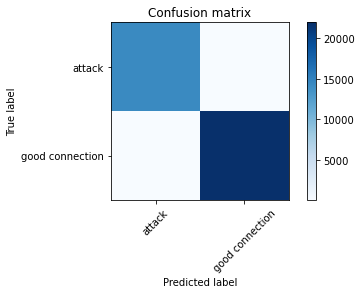

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14417
           1       1.00      1.00      1.00     21980

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [30]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [27]:
#relu with sgd
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

x,y = to_xy(obj_df, "Outcome")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(y.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')





model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor], verbose=2,epochs=100)

Train on 109189 samples, validate on 36397 samples
Epoch 1/100
109189/109189 - 7s - loss: 0.0706 - val_loss: 0.0457
Epoch 2/100
109189/109189 - 7s - loss: 0.0356 - val_loss: 0.0271
Epoch 3/100
109189/109189 - 7s - loss: 0.0266 - val_loss: 0.0241
Epoch 4/100
109189/109189 - 7s - loss: 0.0243 - val_loss: 0.0213
Epoch 5/100
109189/109189 - 7s - loss: 0.0228 - val_loss: 0.0219
Epoch 6/100
109189/109189 - 7s - loss: 0.0225 - val_loss: 0.0196
Epoch 7/100
109189/109189 - 7s - loss: 0.0223 - val_loss: 0.0185
Epoch 8/100
109189/109189 - 7s - loss: 0.0213 - val_loss: 0.0187
Epoch 9/100
109189/109189 - 7s - loss: 0.0208 - val_loss: 0.0181
Epoch 00009: early stopping


In [28]:
# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9917300876445861


[[14357    60]
 [  241 21739]]
Plotting confusion matrix


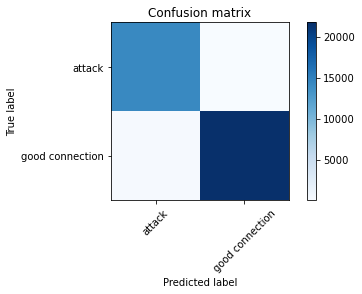

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14417
           1       1.00      0.99      0.99     21980

    accuracy                           0.99     36397
   macro avg       0.99      0.99      0.99     36397
weighted avg       0.99      0.99      0.99     36397



In [29]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [30]:
#sigmoid with sgd
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

x,y = to_xy(obj_df, "Outcome")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='sigmoid'))
model.add(Dense(5,activation='sigmoid'))
model.add(Dense(y.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor], verbose=2,epochs=100)

Train on 109189 samples, validate on 36397 samples
Epoch 1/100
109189/109189 - 8s - loss: 0.2494 - val_loss: 0.1062
Epoch 2/100
109189/109189 - 7s - loss: 0.0890 - val_loss: 0.0767
Epoch 3/100
109189/109189 - 7s - loss: 0.0716 - val_loss: 0.0663
Epoch 4/100
109189/109189 - 7s - loss: 0.0638 - val_loss: 0.0610
Epoch 5/100
109189/109189 - 7s - loss: 0.0595 - val_loss: 0.0578
Epoch 6/100
109189/109189 - 7s - loss: 0.0568 - val_loss: 0.0555
Epoch 7/100
109189/109189 - 8s - loss: 0.0546 - val_loss: 0.0536
Epoch 8/100
109189/109189 - 8s - loss: 0.0527 - val_loss: 0.0517
Epoch 9/100
109189/109189 - 7s - loss: 0.0508 - val_loss: 0.0498
Epoch 10/100
109189/109189 - 7s - loss: 0.0486 - val_loss: 0.0475
Epoch 11/100
109189/109189 - 7s - loss: 0.0461 - val_loss: 0.0445
Epoch 12/100
109189/109189 - 7s - loss: 0.0431 - val_loss: 0.0409
Epoch 13/100
109189/109189 - 7s - loss: 0.0398 - val_loss: 0.0371
Epoch 14/100
109189/109189 - 7s - loss: 0.0361 - val_loss: 0.0332
Epoch 15/100
109189/109189 - 7s - 

In [31]:
# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9969777728933703


[[14350    67]
 [   43 21937]]
Plotting confusion matrix


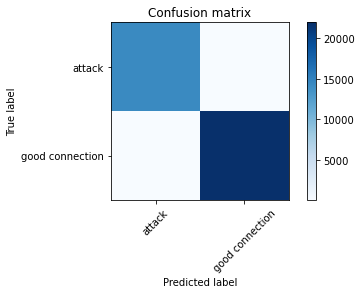

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14417
           1       1.00      1.00      1.00     21980

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [32]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [33]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

x,y = to_xy(obj_df, "Outcome")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='tanh'))
model.add(Dense(5,activation='tanh'))
model.add(Dense(y.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor], verbose=2,epochs=100)

Train on 109189 samples, validate on 36397 samples
Epoch 1/100
109189/109189 - 7s - loss: 0.0888 - val_loss: 0.0537
Epoch 2/100
109189/109189 - 7s - loss: 0.0414 - val_loss: 0.0286
Epoch 3/100
109189/109189 - 7s - loss: 0.0246 - val_loss: 0.0192
Epoch 4/100
109189/109189 - 7s - loss: 0.0188 - val_loss: 0.0146
Epoch 5/100
109189/109189 - 7s - loss: 0.0157 - val_loss: 0.0123
Epoch 6/100
109189/109189 - 7s - loss: 0.0140 - val_loss: 0.0129
Epoch 7/100
109189/109189 - 7s - loss: 0.0133 - val_loss: 0.0104
Epoch 8/100
109189/109189 - 7s - loss: 0.0127 - val_loss: 0.0106
Epoch 9/100
109189/109189 - 7s - loss: 0.0119 - val_loss: 0.0098
Epoch 00009: early stopping


In [34]:
# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.997499793939061


[[14369    48]
 [   43 21937]]
Plotting confusion matrix


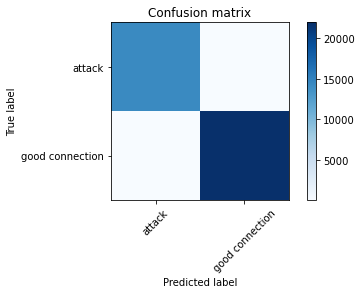

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14417
           1       1.00      1.00      1.00     21980

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [35]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [19]:
#tanh with adam
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

x,y = to_xy(obj_df, "Outcome")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='tanh'))
model.add(Dense(5,activation='tanh'))
model.add(Dense(y.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor], verbose=2,epochs=100)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 109189 samples, validate on 36397 samples
Epoch 1/100
109189/109189 - 3s - loss: 0.0346 - val_loss: 0.0107
Epoch 2/100
109189/109189 - 3s - loss: 0.0115 - val_loss: 0.0075
Epoch 3/100
109189/109189 - 3s - loss: 0.0096 - val_loss: 0.0064
Epoch 4/100
109189/109189 - 3s - loss: 0.0083 - val_loss: 0.0068
Epoch 5/100
109189/109189 - 3s - loss: 0.0076 - val_loss: 0.0052
Epoch 6/100
109189/109189 - 3s - loss: 0.0071 - val_loss: 0.0052
Epoch 7/100
109189/109189 - 3s - loss: 0.0066 - val_loss: 0.0051
Epoch 00007: early stopping


In [20]:
# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9985713108223205


[[14384    33]
 [   19 21961]]
Plotting confusion matrix


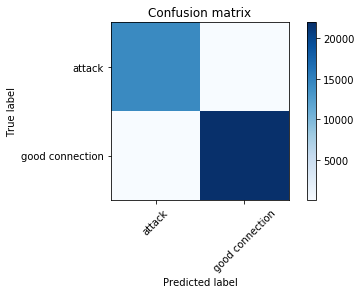

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14417
           1       1.00      1.00      1.00     21980

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [21]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [22]:
score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

Precision score: 0.9985713805355987
Recall score: 0.9985713108223205
F1 score: 0.9985711912383058


In [39]:
#sigmoid with adam
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

x,y = to_xy(obj_df, "Outcome")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='sigmoid'))
model.add(Dense(5,activation='sigmoid'))
model.add(Dense(y.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor], verbose=2,epochs=100)

Train on 109189 samples, validate on 36397 samples
Epoch 1/100
109189/109189 - 8s - loss: 0.1147 - val_loss: 0.0407
Epoch 2/100
109189/109189 - 7s - loss: 0.0220 - val_loss: 0.0123
Epoch 3/100
109189/109189 - 7s - loss: 0.0133 - val_loss: 0.0096
Epoch 4/100
109189/109189 - 7s - loss: 0.0114 - val_loss: 0.0079
Epoch 5/100
109189/109189 - 7s - loss: 0.0103 - val_loss: 0.0071
Epoch 6/100
109189/109189 - 7s - loss: 0.0094 - val_loss: 0.0071
Epoch 00006: early stopping


In [40]:
# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9983515124872929


[[14376    41]
 [   19 21961]]
Plotting confusion matrix


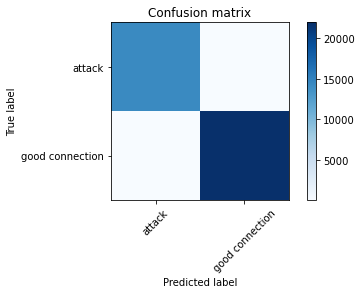

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14417
           1       1.00      1.00      1.00     21980

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [41]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [42]:
#tanh with adam with 4 layers
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

x,y = to_xy(obj_df, "Outcome")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='tanh'))
model.add(Dense(5,activation='tanh'))
model.add(Dense(5,activation='tanh'))
model.add(Dense(5,activation='tanh'))
model.add(Dense(y.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor], verbose=2,epochs=100)

Train on 109189 samples, validate on 36397 samples
Epoch 1/100
109189/109189 - 9s - loss: 0.0432 - val_loss: 0.0140
Epoch 2/100
109189/109189 - 9s - loss: 0.0145 - val_loss: 0.0094
Epoch 3/100
109189/109189 - 8s - loss: 0.0101 - val_loss: 0.0073
Epoch 4/100
109189/109189 - 9s - loss: 0.0087 - val_loss: 0.0063
Epoch 5/100
109189/109189 - 9s - loss: 0.0079 - val_loss: 0.0064
Epoch 6/100
109189/109189 - 8s - loss: 0.0072 - val_loss: 0.0058
Epoch 00006: early stopping


In [43]:
# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9985163612385636


[[14377    40]
 [   14 21966]]
Plotting confusion matrix


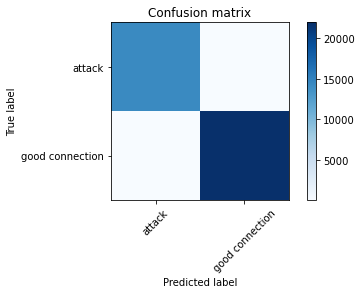

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14417
           1       1.00      1.00      1.00     21980

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [44]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [31]:
#tanh with adam with 4 layers neuron 20 15 10 5
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

x,y = to_xy(obj_df, "Outcome")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(20, input_dim=x.shape[1], activation='tanh'))
model.add(Dense(15,activation='tanh'))
model.add(Dense(10,activation='tanh'))
model.add(Dense(5,activation='tanh'))
model.add(Dense(y.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor], verbose=2,epochs=100)

Train on 109189 samples, validate on 36397 samples
Epoch 1/100
109189/109189 - 4s - loss: 0.0257 - val_loss: 0.0091
Epoch 2/100
109189/109189 - 3s - loss: 0.0099 - val_loss: 0.0076
Epoch 3/100
109189/109189 - 3s - loss: 0.0081 - val_loss: 0.0054
Epoch 4/100
109189/109189 - 3s - loss: 0.0072 - val_loss: 0.0056
Epoch 5/100
109189/109189 - 3s - loss: 0.0068 - val_loss: 0.0094
Epoch 00005: early stopping


In [32]:
# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9976371678984531


[[14392    25]
 [   61 21919]]
Plotting confusion matrix


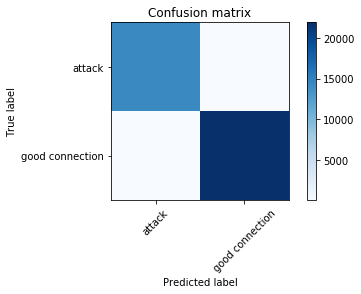

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14417
           1       1.00      1.00      1.00     21980

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [33]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [34]:
score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

Precision score: 0.9976402156025128
Recall score: 0.9976371678984531
F1 score: 0.9976376728022222


In [36]:
x,y = to_xy(obj_df, "Outcome")

x = x.reshape((x.shape[0],1,x.shape[1],1))

x.shape

(145586, 1, 120, 1)

In [24]:
# Load modules
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# define a CNN


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, x.shape[2], 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(64, kernel_size=(1, 2), strides=(1, 1),
                 activation='relu'))

cnn.add(MaxPooling2D(pool_size=(1,2)))
      
cnn.add(Flatten())
cnn.add(Dense(100, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="adam")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

cnn.fit(x_train,y_train,epochs=10,verbose=2,batch_size=123, callbacks=[monitor],validation_data=(x_test, y_test))
        

Train on 109189 samples, validate on 36397 samples
Epoch 1/10
109189/109189 - 12s - loss: 0.0343 - val_loss: 0.0117
Epoch 2/10
109189/109189 - 15s - loss: 0.0148 - val_loss: 0.0114
Epoch 3/10
109189/109189 - 14s - loss: 0.0125 - val_loss: 0.0096
Epoch 4/10
109189/109189 - 12s - loss: 0.0109 - val_loss: 0.0090
Epoch 5/10
109189/109189 - 13s - loss: 0.0106 - val_loss: 0.0085
Epoch 6/10
109189/109189 - 13s - loss: 0.0092 - val_loss: 0.0077
Epoch 7/10
109189/109189 - 11s - loss: 0.0086 - val_loss: 0.0076
Epoch 00007: early stopping


In [26]:
# Measure accuracy
pred = cnn.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9983789872791714


[[14386    31]
 [   28 21952]]
Plotting confusion matrix


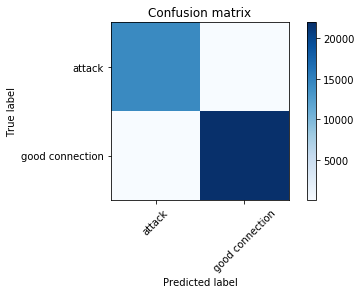

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14417
           1       1.00      1.00      1.00     21980

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [27]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [28]:
score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

Precision score: 0.9983789433984733
Recall score: 0.9983789872791714
F1 score: 0.9983789582505114


In [32]:
# Load modules
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# define a CNN


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1),
                 activation='sigmoid',
                 input_shape=(1, x.shape[2], 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(64, kernel_size=(1, 2), strides=(1, 1),
                 activation='sigmoid'))

cnn.add(MaxPooling2D(pool_size=(1,2)))
      
cnn.add(Flatten())
cnn.add(Dense(100, activation="sigmoid"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="adam")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

cnn.fit(x_train,y_train,epochs=10,verbose=2,batch_size=123, callbacks=[monitor],validation_data=(x_test, y_test))

Train on 109189 samples, validate on 36397 samples
Epoch 1/10
109189/109189 - 14s - loss: 0.2587 - val_loss: 0.0480
Epoch 2/10
109189/109189 - 14s - loss: 0.0345 - val_loss: 0.0206
Epoch 3/10
109189/109189 - 13s - loss: 0.0229 - val_loss: 0.0150
Epoch 4/10
109189/109189 - 13s - loss: 0.0190 - val_loss: 0.0129
Epoch 5/10
109189/109189 - 14s - loss: 0.0163 - val_loss: 0.0103
Epoch 6/10
109189/109189 - 14s - loss: 0.0150 - val_loss: 0.0091
Epoch 7/10
109189/109189 - 13s - loss: 0.0134 - val_loss: 0.0098
Epoch 8/10
109189/109189 - 15s - loss: 0.0123 - val_loss: 0.0079
Epoch 9/10
109189/109189 - 13s - loss: 0.0120 - val_loss: 0.0076
Epoch 10/10
109189/109189 - 13s - loss: 0.0109 - val_loss: 0.0097
Epoch 00010: early stopping


In [36]:
# Measure accuracy
pred = cnn.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9966206005989504


[[14382    35]
 [   88 21892]]
Plotting confusion matrix


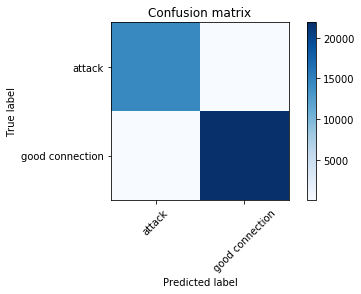

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     14417
           1       1.00      1.00      1.00     21980

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [38]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [40]:
# Load modules
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# define a CNN


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1),
                 activation='tanh',
                 input_shape=(1, x.shape[2], 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(64, kernel_size=(1, 2), strides=(1, 1),
                 activation='tanh'))

cnn.add(MaxPooling2D(pool_size=(1,2)))
      
cnn.add(Flatten())
cnn.add(Dense(100, activation="tanh"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="adam")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

cnn.fit(x_train,y_train,epochs=10,verbose=2,batch_size=123, callbacks=[monitor],validation_data=(x_test, y_test))

Train on 109189 samples, validate on 36397 samples
Epoch 1/10
109189/109189 - 12s - loss: 0.0275 - val_loss: 0.0106
Epoch 2/10
109189/109189 - 13s - loss: 0.0146 - val_loss: 0.0081
Epoch 3/10
109189/109189 - 12s - loss: 0.0119 - val_loss: 0.0071
Epoch 4/10
109189/109189 - 13s - loss: 0.0106 - val_loss: 0.0063
Epoch 5/10
109189/109189 - 13s - loss: 0.0095 - val_loss: 0.0061
Epoch 00005: early stopping


In [41]:
# Measure accuracy
pred = cnn.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.99804928977663


[[14384    33]
 [   38 21942]]
Plotting confusion matrix


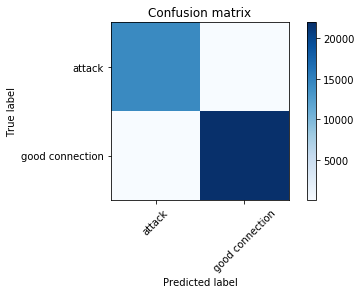

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14417
           1       1.00      1.00      1.00     21980

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [42]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [43]:
# Load modules
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# define a CNN


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, x.shape[2], 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(64, kernel_size=(1, 2), strides=(1, 1),
                 activation='relu'))

cnn.add(MaxPooling2D(pool_size=(1,2)))
      
cnn.add(Flatten())
cnn.add(Dense(100, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="sgd")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

cnn.fit(x_train,y_train,epochs=10,verbose=2,batch_size=123, callbacks=[monitor],validation_data=(x_test, y_test))

Train on 109189 samples, validate on 36397 samples
Epoch 1/10
109189/109189 - 11s - loss: 0.1483 - val_loss: 0.0663
Epoch 2/10
109189/109189 - 11s - loss: 0.0680 - val_loss: 0.0477
Epoch 3/10
109189/109189 - 11s - loss: 0.0502 - val_loss: 0.0333
Epoch 4/10
109189/109189 - 11s - loss: 0.0377 - val_loss: 0.0250
Epoch 5/10
109189/109189 - 11s - loss: 0.0305 - val_loss: 0.0207
Epoch 6/10
109189/109189 - 11s - loss: 0.0273 - val_loss: 0.0185
Epoch 7/10
109189/109189 - 11s - loss: 0.0239 - val_loss: 0.0167
Epoch 8/10
109189/109189 - 11s - loss: 0.0229 - val_loss: 0.0159
Epoch 9/10
109189/109189 - 11s - loss: 0.0211 - val_loss: 0.0152
Epoch 10/10
109189/109189 - 11s - loss: 0.0206 - val_loss: 0.0147


In [44]:
# Measure accuracy
pred = cnn.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9962084787207737


[[14360    57]
 [   81 21899]]
Plotting confusion matrix


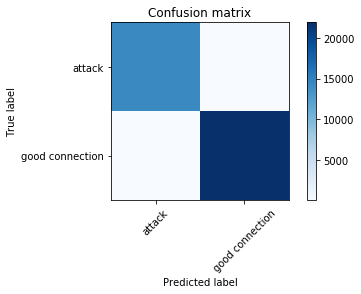

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     14417
           1       1.00      1.00      1.00     21980

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [45]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [37]:
# Load modules
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# define a CNN


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1),
                 activation='sigmoid',
                 input_shape=(1, x.shape[2], 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(64, kernel_size=(1, 2), strides=(1, 1),
                 activation='sigmoid'))

cnn.add(MaxPooling2D(pool_size=(1,2)))
      
cnn.add(Flatten())
cnn.add(Dense(100, activation="sigmoid"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="sgd")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

cnn.fit(x_train,y_train,epochs=10,verbose=2,batch_size=123, callbacks=[monitor],validation_data=(x_test, y_test))

Train on 109189 samples, validate on 36397 samples
Epoch 1/10
109189/109189 - 12s - loss: 0.6910 - val_loss: 0.6705
Epoch 2/10
109189/109189 - 14s - loss: 0.6739 - val_loss: 0.6700
Epoch 3/10
109189/109189 - 12s - loss: 0.6725 - val_loss: 0.6699
Epoch 00003: early stopping


In [38]:
# Measure accuracy
pred = cnn.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.6038959254883645


[[    0 14417]
 [    0 21980]]
Plotting confusion matrix


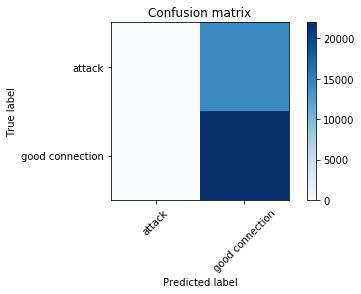

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     14417
           1       0.60      1.00      0.75     21980

    accuracy                           0.60     36397
   macro avg       0.30      0.50      0.38     36397
weighted avg       0.36      0.60      0.45     36397



C:\Users\jacob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [40]:
score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

Precision score: 0.3646902888214482
Recall score: 0.6038959254883645
F1 score: 0.4547555524344947


C:\Users\jacob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
# Load modules
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# define a CNN


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1),
                 activation='tanh',
                 input_shape=(1, x.shape[2], 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(64, kernel_size=(1, 2), strides=(1, 1),
                 activation='tanh'))

cnn.add(MaxPooling2D(pool_size=(1,2)))
      
cnn.add(Flatten())
cnn.add(Dense(100, activation="tanh"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="sgd")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

cnn.fit(x_train,y_train,epochs=10,verbose=2,batch_size=123, callbacks=[monitor],validation_data=(x_test, y_test))

Train on 109189 samples, validate on 36397 samples
Epoch 1/10
109189/109189 - 11s - loss: 0.1077 - val_loss: 0.0626
Epoch 2/10
109189/109189 - 11s - loss: 0.0578 - val_loss: 0.0469
Epoch 3/10
109189/109189 - 11s - loss: 0.0457 - val_loss: 0.0363
Epoch 4/10
109189/109189 - 11s - loss: 0.0362 - val_loss: 0.0289
Epoch 5/10
109189/109189 - 11s - loss: 0.0303 - val_loss: 0.0242
Epoch 6/10
109189/109189 - 11s - loss: 0.0264 - val_loss: 0.0214
Epoch 7/10
109189/109189 - 11s - loss: 0.0240 - val_loss: 0.0192
Epoch 8/10
109189/109189 - 11s - loss: 0.0221 - val_loss: 0.0177
Epoch 9/10
109189/109189 - 11s - loss: 0.0208 - val_loss: 0.0167
Epoch 10/10
109189/109189 - 11s - loss: 0.0198 - val_loss: 0.0159


In [53]:
# Measure accuracy
pred = cnn.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9956040332994478


[[14323    94]
 [   66 21914]]
Plotting confusion matrix


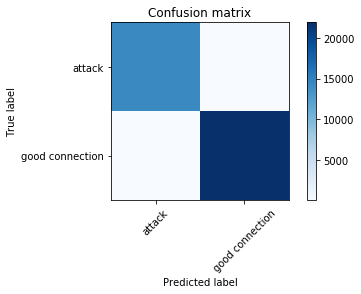

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     14417
           1       1.00      1.00      1.00     21980

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [54]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [55]:
# Load modules
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# define a CNN


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, 2), strides=(1, 1),
                 activation='tanh',
                 input_shape=(1, x.shape[2], 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(128, kernel_size=(1, 2), strides=(1, 1),
                 activation='tanh'))

cnn.add(MaxPooling2D(pool_size=(1,2)))
      
cnn.add(Flatten())
cnn.add(Dense(100, activation="tanh"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="sgd")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

cnn.fit(x_train,y_train,epochs=10,verbose=2,batch_size=123, callbacks=[monitor],validation_data=(x_test, y_test))

Train on 109189 samples, validate on 36397 samples
Epoch 1/10
109189/109189 - 22s - loss: 0.1067 - val_loss: 0.0630
Epoch 2/10
109189/109189 - 21s - loss: 0.0584 - val_loss: 0.0492
Epoch 3/10
109189/109189 - 21s - loss: 0.0470 - val_loss: 0.0390
Epoch 4/10
109189/109189 - 21s - loss: 0.0385 - val_loss: 0.0311
Epoch 5/10
109189/109189 - 21s - loss: 0.0316 - val_loss: 0.0252
Epoch 6/10
109189/109189 - 21s - loss: 0.0267 - val_loss: 0.0216
Epoch 7/10
109189/109189 - 21s - loss: 0.0237 - val_loss: 0.0190
Epoch 8/10
109189/109189 - 21s - loss: 0.0215 - val_loss: 0.0173
Epoch 9/10
109189/109189 - 21s - loss: 0.0201 - val_loss: 0.0162
Epoch 10/10
109189/109189 - 21s - loss: 0.0193 - val_loss: 0.0154


In [56]:
# Measure accuracy
pred = cnn.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.99574140725884


[[14332    85]
 [   70 21910]]
Plotting confusion matrix


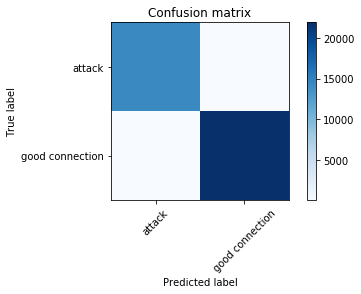

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     14417
           1       1.00      1.00      1.00     21980

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [58]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [59]:
# Load modules
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# define a CNN


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),
                 activation='tanh',
                 input_shape=(1, x.shape[2], 1)))

cnn.add(MaxPooling2D(pool_size=(1,3)))

cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='tanh'))

cnn.add(MaxPooling2D(pool_size=(1,3)))
      
cnn.add(Flatten())
cnn.add(Dense(100, activation="tanh"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="sgd")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

cnn.fit(x_train,y_train,epochs=10,verbose=2,batch_size=123, callbacks=[monitor],validation_data=(x_test, y_test))

Train on 109189 samples, validate on 36397 samples
Epoch 1/10
109189/109189 - 10s - loss: 0.1559 - val_loss: 0.0849
Epoch 2/10
109189/109189 - 10s - loss: 0.0769 - val_loss: 0.0645
Epoch 3/10
109189/109189 - 9s - loss: 0.0619 - val_loss: 0.0535
Epoch 4/10
109189/109189 - 9s - loss: 0.0521 - val_loss: 0.0449
Epoch 5/10
109189/109189 - 9s - loss: 0.0445 - val_loss: 0.0376
Epoch 6/10
109189/109189 - 9s - loss: 0.0380 - val_loss: 0.0317
Epoch 7/10
109189/109189 - 9s - loss: 0.0333 - val_loss: 0.0279
Epoch 8/10
109189/109189 - 9s - loss: 0.0297 - val_loss: 0.0241
Epoch 9/10
109189/109189 - 10s - loss: 0.0268 - val_loss: 0.0217
Epoch 10/10
109189/109189 - 9s - loss: 0.0248 - val_loss: 0.0200


In [60]:
# Measure accuracy
pred = cnn.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9936533230760777


[[14275   142]
 [   89 21891]]
Plotting confusion matrix


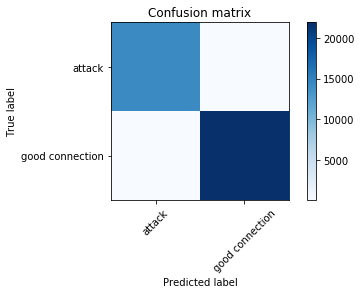

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14417
           1       0.99      1.00      0.99     21980

    accuracy                           0.99     36397
   macro avg       0.99      0.99      0.99     36397
weighted avg       0.99      0.99      0.99     36397



In [61]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))

In [62]:
# Load modules
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# define a CNN


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1),
                 activation='tanh',
                 input_shape=(1, x.shape[2], 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(64, kernel_size=(1, 2), strides=(1, 1),
                 activation='tanh'))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(128, kernel_size=(1, 2), strides=(1, 1),
                 activation='tanh',
                 input_shape=(1, x.shape[2], 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))
      
cnn.add(Flatten())
cnn.add(Dense(100, activation="tanh"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="sgd")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')

cnn.fit(x_train,y_train,epochs=10,verbose=2,batch_size=123, callbacks=[monitor],validation_data=(x_test, y_test))

Train on 109189 samples, validate on 36397 samples
Epoch 1/10
109189/109189 - 17s - loss: 0.1385 - val_loss: 0.0728
Epoch 2/10
109189/109189 - 17s - loss: 0.0645 - val_loss: 0.0520
Epoch 3/10
109189/109189 - 17s - loss: 0.0482 - val_loss: 0.0386
Epoch 4/10
109189/109189 - 17s - loss: 0.0375 - val_loss: 0.0300
Epoch 5/10
109189/109189 - 17s - loss: 0.0302 - val_loss: 0.0241
Epoch 6/10
109189/109189 - 17s - loss: 0.0259 - val_loss: 0.0206
Epoch 7/10
109189/109189 - 17s - loss: 0.0232 - val_loss: 0.0184
Epoch 8/10
109189/109189 - 16s - loss: 0.0215 - val_loss: 0.0169
Epoch 9/10
109189/109189 - 17s - loss: 0.0199 - val_loss: 0.0160
Epoch 10/10
109189/109189 - 17s - loss: 0.0190 - val_loss: 0.0149


In [63]:
# Measure accuracy
pred = cnn.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.996043629969503


[[14339    78]
 [   66 21914]]
Plotting confusion matrix


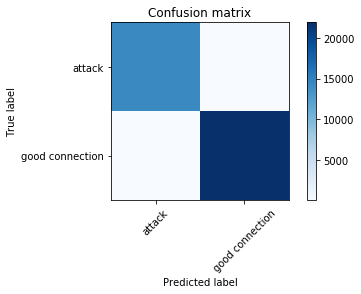

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     14417
           1       1.00      1.00      1.00     21980

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



In [64]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, Outcome)
plt.show()

print(classification_report(y_true, pred))